('A', 'B', 'C', 'S', 'W', 'Y')


               日期      年月             客户编码     金额  区域 类型
164479 2017-12-26  201712  08300410050AXXA  126.0  08  A
164480 2017-12-26  201712  08400080080SXXD  210.0  08  S
164481 2017-12-26  201712  08400370000SXXD  102.8  08  S
164482 2017-12-26  201712  08500060100SXXD   88.0  08  S
日期      datetime64[ns]
年月              object
客户编码            object
金额             float64
区域              object
类型              object
dtype: object
float64
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>换货单号
DatetimeIndex(['2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
               '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22',
               '2017-08-23', '2017-08-24',
               ...
               '2017-12-17', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26'],
              dtype='datetime64[ns]', length=134, freq='D')
6.0	25.0	42.0	43.0	45.0	45.0	61.0	67.0	68.0	81.

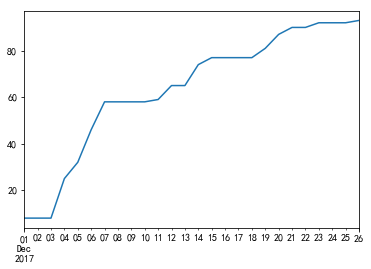

In [18]:
from imp4nb import *

cnx = lite.connect('data\\quandan.db')

start = time.clock()
dfleixing= pd.read_sql('select * from leixing',cnx,index_col='index')
# print(dfleixing)
leixing = tuple((dfleixing[dfleixing['类型'] == '终端客户'])['编码'])
print(leixing)
df = pd.read_sql_query("select 日期,strftime('%Y%m',日期) as 年月,customer.往来单位编号 as 客户编码,sum(金额) as 金额,"
                       "substr(customer.往来单位编号,1,2) as 区域 ,"  "substr(customer.往来单位编号,12,1) as 类型 "
                       "from xiaoshoumingxi, customer where (customer.往来单位 = xiaoshoumingxi.单位全名)"
                       " group by 日期,客户编码 order by 日期",cnx)

df['日期'] = df['日期'].apply(lambda x: pd.to_datetime(x))
# print(df.tail(5))
dfs = df.iloc[-11100:] # 切片做实验
dfs = dfs[(dfs.类型.isin(leixing).values == True) & (dfs.区域 =='08')]
print(dfs.tail(4))
print(dfs.dtypes)
dfmoban = dfs.groupby('日期')['金额'].sum() # 获得按照日期汇总后的DataFrame，日期唯一，值其实随意，这里随意取了当天的最高客户销售额
dffff = dfmoban
dffff.index = pd.to_datetime(dffff.index)
print(dffff.dtypes)
print(str(type(dffff.index))+'换货单号')
dates = pd.date_range(dfmoban.index.min(),periods=(dfmoban.index.max() - dfmoban.index.min()).days +1,freq='D')
print(dates)
dfmoban = dfmoban.reindex(dates,fill_value=0)

for ix in dfmoban.index:
    ixyuechudate = pd.to_datetime("%04d-%02d-01" %(ix.year,ix.month))
    dftmp = ((dfs[(dfs.日期 >= ixyuechudate) & (dfs.日期 <= ix)]).groupby('客户编码'))['金额'].sum()
    # print(dfmoban.loc[ix],end='\t')
    dfmoban[ix] = dftmp.shape[0]
    print(dfmoban[ix],end='\t')
print()

dfmoban[dfmoban.index >= pd.to_datetime('2017-12-01')].plot()
plt.show()
# finish1 = time.clock()
# print(dftarget)
# print(dftarget.index)
# finish2 = time.clock()
# # dftmp = dftarget[(dftarget.index >= '2017-12-01 00:00:00') & (df.index <= '2017-12-09 00:00:00')]
# dftmp = dftarget['2017-12-01 00:00:00':'2017-12-09 00:00:00']
# print(dftmp)
# print(dftmp.index)
# cnm = lite.connect(':memory:')
# df.to_sql('griqidanwei',cnm, if_exists='replace')
# dfm = pd.read_sql_query("select sum(金额) as 销售额 from griqidanwei where 日期 >= '2017-12-01' group by 客户编码" ,cnm)
# cnm.close()
# print(len(dfm))
# print(dfm)

# print("起始：%f，读取数据构建DataFrame：%f，描述DataFrame：%f。" %(start,finish1-start,finish2-finish1))

# dfcm = df.duplicated()
# print(list(dfcm[dfcm == True].index))
# df =df.drop_duplicates()
# descdb(df)

cnx.close()

In [6]:
# 关联客户信息和产品信息
from imp4nb import *

cnx = lite.connect('data\\quandan.db')
# desclitedb(cnx)

# cur = cnx.cursor()
# result = cur.execute('select * from xiaoshoumingxi')
# colnames = [tuple1[0] for tuple1 in result.description]
# print(colnames)
# print(len(result.fetchall()))
# print(result.fetchone()[0])

# df = pd.read_sql_query(
#     "select 日期,职员名称 as 业务主管,单据编号 as 销售单号,商品备注 as 订单单号,单据类型,摘要,xiaoshoumingxi.单位全名 as 客户,customer.往来单位编号 as 编码,"
#     "xiaoshoumingxi.商品全名 as 商品全名,数量,xiaoshoumingxi.单价,金额,substr(customer.往来单位编号,1,2) as 大区 ,"
#     "substr(customer.往来单位编号,1,3) as 小区 ,quyu.分部 as 分部,"
#     "substr(customer.往来单位编号,12,1) as 类型编码,leixing.类型 as 客户类型, product.品牌名称  as 品牌 ,product.品牌分类  as 品牌分类 from xiaoshoumingxi,"
#     "customer,product,quyu,leixing where (customer.往来单位 = xiaoshoumingxi.单位全名)  and (大区 = quyu.区域) "
#     "and (product.商品全名 = xiaoshoumingxi.商品全名) and (类型编码 = leixing.编码) order by 日期 desc", cnx,parse_dates=['日期'])
tm0 = time.clock()

df = pd.read_sql_query("select * from xiaoshoumingxi",cnx)
# descdb(df)
log.info('数据表“销售明细”中有%d条记录' %(len(df)))
tm1 = time.clock()

df = pd.read_sql_query(
    "select 日期,职员名称 as 业务主管,单据编号 as 销售单号,商品备注 as 订单单号,单据类型,摘要,xiaoshoumingxi.单位全名 as 客户,customer.往来单位编号 as 编码,"
    "xiaoshoumingxi.商品全名 as 商品全名,数量,xiaoshoumingxi.单价,金额,substr(customer.往来单位编号,1,2) as 大区 ,"
    "substr(customer.往来单位编号,1,3) as 小区 ,quyu.分部 as 分部,"
    "substr(customer.往来单位编号,12,1) as 类型编码, product.品牌名称  as 品牌 ,product.品牌分类  as 品牌分类 from xiaoshoumingxi,"
    "customer,product,quyu where (customer.往来单位 = xiaoshoumingxi.单位全名)  and (大区 = quyu.区域) "
    "and (product.商品全名 = xiaoshoumingxi.商品全名) order by 日期 desc", cnx)
# descdb(df)
log.info('数据表“销售明细”和“客户”、“品牌”、“区域”关联后有效记录数为：%d条' %(len(df)))
tm2 = time.clock()

df['日期'] = df['日期'].apply(lambda x: pd.to_datetime(x))
log.debug('处理关联客户品牌区域等信息的数据表，把‘日期’处理成了日期格式')
tm3 = time.clock()

# cnm = lite.connect(":memory:")
# df.to_sql(name='alldata', con=cnx, if_exists='replace',chunksize=50000)
df.to_sql(name='alldata', con=cnx, if_exists='replace')
log.info('把关联并规整后的数据写入了“alldata”数据表')
# cnm.close()
tm4 = time.clock()

df = pd.read_sql_query('select 日期,sum(金额) as 销售额 from alldata group by 日期',cnx)
# descdb(df)
tm5 = time.clock()

cnx.close()

print("起始时间：%f，从销售明细读取所有记录获取记录数：%f；"
      "关联客户、品牌和区域信息获得处理后的记录：%f；"
      "处理日期列：%f；"
      "写入内存数据库：%f；"
      "从存储数据库读取汇总销售数据：%f。" %(tm0,tm1-tm0,tm2-tm1,tm3-tm2,tm4-tm3,tm5-tm4))


2017-12-25 01:09:51,180	ewer        : INFO     数据表“销售明细”中有1444120条记录
2017-12-25 01:11:28,556	ewer        : INFO     数据表“销售明细”和“客户”、“品牌”、“区域”关联后有效记录数为：1444120条
2017-12-25 01:12:58,179	ewer        : DEBUG    处理关联客户品牌区域等信息的数据表，把‘日期’处理成了日期格式
2017-12-25 01:22:45,570	ewer        : INFO     把关联并规整后的数据写入了“alldata”数据表


起始时间：6572.674710，从销售明细读取所有记录获取记录数：81.736487；关联客户、品牌和区域信息获得处理后的记录：97.349337；处理日期列：89.625873；写入内存数据库：587.361965；从存储数据库读取汇总销售数据：1.058238。


In [3]:
from imp4nb import *

cnx = lite.connect('data\\quandan.db')

df = pd.read_sql_query("select * from xiaoshoumingxi",cnx)
print(len(df))

df = pd.read_sql_query("select * from alldata",cnx)
print(len(df))


cnx.close()

1444120
1434642
